In [2]:
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import pandas as pd
from io import StringIO
from sklearn.model_selection import train_test_split
import seaborn as sns

# =======================
# Dataset Loaders
# =======================
def load_iris_dataset():
    """Load Iris dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
    column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
    try:
        response = urlopen(url)
        data = response.read().decode('utf-8')
        df = pd.read_csv(StringIO(data), header=None, names=column_names)
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values
        return X, y, column_names[:-1], np.unique(y)
    except:
        print("Error loading Iris dataset from URL. Using synthetic data instead.")
        # Create synthetic Iris data if URL fails
        from sklearn.datasets import load_iris
        iris = load_iris()
        X = iris.data
        y = np.array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])[iris.target]
        return X, y, iris.feature_names, np.unique(y)

def load_breast_cancer_coimbra_dataset():
    """Load Breast Cancer Coimbra dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00451/dataR2.csv"
    try:
        response = urlopen(url)
        data = response.read().decode('utf-8')
        df = pd.read_csv(StringIO(data))
        X = df.iloc[:, :-1].values  # Features
        y = df.iloc[:, -1].values   # Classification column
        # Convert class to strings for consistency
        y = np.array(['Healthy' if label == 1 else 'Patient' for label in y])
        feature_names = df.columns[:-1].tolist()
        class_names = np.unique(y)
        return X, y, feature_names, class_names
    except:
        print("Error loading Breast Cancer Coimbra dataset from URL. Generating synthetic data instead.")
        # Generate synthetic data if URL fails
        np.random.seed(42)
        n_samples = 116  # Actual dataset size
        n_features = 9   # Actual number of features
        X = np.random.randn(n_samples, n_features)
        y = np.array(['Healthy' if i < 58 else 'Patient' for i in range(n_samples)])
        feature_names = [
            'Age', 'BMI', 'Glucose', 'Insulin', 'HOMA', 'Leptin',
            'Adiponectin', 'Resistin', 'MCP.1'
        ]
        class_names = np.unique(y)
        return X, y, feature_names, class_names

def load_ionosphere_dataset():
    """Load Ionosphere dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
    column_names = [f'feature_{i}' for i in range(34)] + ['class']
    try:
        response = urlopen(url)
        data = response.read().decode('utf-8')
        df = pd.read_csv(StringIO(data), header=None, names=column_names)
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values
        feature_names = column_names[:-1]
        class_names = np.unique(y)
        return X, y, feature_names, class_names
    except:
        print("Error loading Ionosphere dataset from URL. Using synthetic data instead.")
        # Create synthetic ionosphere data if URL fails
        X = np.random.randn(351, 34)
        y = np.random.choice(['g', 'b'], size=351)
        feature_names = [f'feature_{i}' for i in range(34)]
        return X, y, feature_names, np.unique(y)

def load_wine_dataset():
    """Load Wine dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
    column_names = ['class', 'alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
                   'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins',
                   'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
    try:
        response = urlopen(url)
        data = response.read().decode('utf-8')
        df = pd.read_csv(StringIO(data), header=None, names=column_names)
        X = df.iloc[:, 1:].values  # Features
        y = df.iloc[:, 0].values   # Class column
        # Convert class to strings for consistency
        y = np.array([f'Class_{int(label)}' for label in y])
        feature_names = column_names[1:]
        class_names = np.unique(y)
        return X, y, feature_names, class_names
    except:
        print("Error loading Wine dataset from URL. Using synthetic data instead.")
        # Create synthetic wine data if URL fails
        from sklearn.datasets import load_wine
        wine = load_wine()
        X = wine.data
        y = np.array([f'Class_{i+1}' for i in wine.target])
        return X, y, wine.feature_names, np.unique(y)

# =======================
# FLD / LDA Projection
# =======================
def lda_projection(X, y, num_components=1):
    """
    LDA projection to reduce data to 'num_components' dimensions.
    - num_components: The number of components to project onto.
      (1 for 2 classes, 2 for 3 classes)
    """
    class_labels = np.unique(y)
    mean_total = np.mean(X, axis=0)
    Sw = np.zeros((X.shape[1], X.shape[1]))
    Sb = np.zeros((X.shape[1], X.shape[1]))

    # Calculate Sw and Sb
    for c in class_labels:
        X_c = X[y == c]
        mean_c = np.mean(X_c, axis=0)
        Sw += (X_c - mean_c).T @ (X_c - mean_c)
        mean_diff = (mean_c - mean_total).reshape(-1, 1)
        Sb += X_c.shape[0] * (mean_diff @ mean_diff.T)

    # Compute the eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(Sw).dot(Sb))

    # Sort eigenvalues in descending order and pick the top 'num_components'
    sorted_indices = np.argsort(eigvals)[::-1]  # Indices of eigenvalues in descending order
    top_eigenvectors = eigvecs[:, sorted_indices[:num_components]]  # Select top 'num_components' eigenvectors

    return top_eigenvectors.real, Sb, Sw

def project_data(X, W):
    """
    Project data onto the lower-dimensional subspace defined by W.
    - W: Matrix containing eigenvectors (e.g., top eigenvectors for LDA).
    """
    return X @ W


# =======================
# PCA Implementation
# =======================
def pca_fit(X, num_components):
    X_centered = X - np.mean(X, axis=0)
    cov = np.cov(X_centered, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov)
    idx = np.argsort(eigvals)[::-1]
    return eigvecs[:, idx[:num_components]]

def pca_transform(X, components):
    return (X - np.mean(X, axis=0)) @ components

# =======================
# Naive Bayes Classifier
# =======================
class NaiveBayesClassifier:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.mean = {}
        self.var = {}
        self.priors = {}
        for c in self.classes:
            X_c = X[y == c]
            self.mean[c] = X_c.mean(axis=0)
            self.var[c] = X_c.var(axis=0) + 1e-6  # add small value to prevent div by zero
            self.priors[c] = X_c.shape[0] / X.shape[0]

    def _log_likelihood(self, x, c):
        prior = np.log(self.priors[c])
        likelihood = -0.5 * np.sum(np.log(2 * np.pi * self.var[c]))
        likelihood -= 0.5 * np.sum(((x - self.mean[c])**2) / self.var[c])
        return prior + likelihood

    def predict(self, X):
        preds = []
        for x in X:
            probs = [self._log_likelihood(x, c) for c in self.classes]
            preds.append(self.classes[np.argmax(probs)])
        return np.array(preds)

    def predict_log_proba(self, X):
        log_proba = []
        for x in X:
            log_probs = np.array([self._log_likelihood(x, c) for c in self.classes])
            log_probs -= np.max(log_probs)  # for numerical stability
            probs = np.exp(log_probs)
            probs /= probs.sum()

            # Avoid log(0) by adding a small epsilon to probs
            log_proba.append(np.log(probs + 1e-10))  # add small value to avoid log(0)
        return np.array(log_proba)


    def predict_proba(self, X):
        return np.exp(self.predict_log_proba(X))


# =======================
# Perceptron Classifier
# =======================
class PerceptronClassifier:
    def __init__(self, lr=0.01, epochs=1000):
        self.lr = lr
        self.epochs = epochs

    def fit(self, X, y):
        self.classes = np.unique(y)
        y_bin = np.where(y == self.classes[0], -1, 1)
        self.w = np.zeros(X.shape[1])
        self.b = 0

        for _ in range(self.epochs):
            for i in range(X.shape[0]):
                if y_bin[i] * (np.dot(X[i], self.w) + self.b) <= 0:
                    self.w += self.lr * y_bin[i] * X[i]
                    self.b += self.lr * y_bin[i]

    def predict(self, X):
        preds = np.dot(X, self.w) + self.b
        return np.where(preds > 0, self.classes[1], self.classes[0])

# =======================
# Evaluation Metrics
# =======================
def manual_confusion_matrix(y_true, y_pred, labels):
    matrix = np.zeros((len(labels), len(labels)), dtype=int)
    label_to_index = {label: i for i, label in enumerate(labels)}
    for t, p in zip(y_true, y_pred):
        matrix[label_to_index[t], label_to_index[p]] += 1
    return matrix

def manual_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def manual_precision(y_true, y_pred, positive_class):
    tp = np.sum((y_pred == positive_class) & (y_true == positive_class))
    fp = np.sum((y_pred == positive_class) & (y_true != positive_class))
    return tp / (tp + fp + 1e-10)

def manual_recall(y_true, y_pred, positive_class):
    tp = np.sum((y_pred == positive_class) & (y_true == positive_class))
    fn = np.sum((y_pred != positive_class) & (y_true == positive_class))
    return tp / (tp + fn + 1e-10)

def manual_f1(precision, recall):
    return 2 * precision * recall / (precision + recall + 1e-10)

def macro_avg_metrics(y_true, y_pred, labels):
    precisions, recalls, f1s = [], [], []
    for label in labels:
        p = manual_precision(y_true, y_pred, label)
        r = manual_recall(y_true, y_pred, label)
        f1 = manual_f1(p, r)
        precisions.append(p)
        recalls.append(r)
        f1s.append(f1)
    return {
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls),
        "F1 Score": np.mean(f1s)
    }

def manual_roc_auc(y_true, y_score, pos_label=1):
    desc_score_indices = np.argsort(-y_score)
    y_true_sorted = np.array(y_true)[desc_score_indices]
    y_score_sorted = np.array(y_score)[desc_score_indices]

    tpr = []
    fpr = []
    P = np.sum(y_true == pos_label)
    N = len(y_true) - P
    tp = 0
    fp = 0

    for i in range(len(y_score_sorted)):
        if y_true_sorted[i] == pos_label:
            tp += 1
        else:
            fp += 1
        tpr.append(tp / P)
        fpr.append(fp / N)

    auc = np.trapezoid(tpr, fpr)
    return fpr, tpr, auc


def plot_confusion_matrices(cm_data):
    n = len(cm_data)
    orig_rows = 3
    orig_cols = 2

    assert n == orig_rows * orig_cols, "cm_data 的長度應該為 6（3列×2行）"


    reordered = []
    for col in range(orig_cols):
        for row in range(orig_rows):
            reordered.append(cm_data[row * orig_cols + col])


    rows, cols = orig_cols, orig_rows
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))

    for ax, (cm, labels, title) in zip(axs.flat, reordered):
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues", ax=ax)
        ax.set_title(title)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

def plot_individual_roc_curves(roc_data):
    n = len(roc_data)
    orig_rows = 3
    orig_cols = 2

    assert n == orig_rows * orig_cols, "roc_data should contain exactly 6 entries (3 rows × 2 cols)"

    # Reorder for column-wise display like confusion matrices
    reordered = []
    for col in range(orig_cols):
        for row in range(orig_rows):
            reordered.append(roc_data[row * orig_cols + col])

    rows, cols = orig_cols, orig_rows
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))

    for ax, (fpr, tpr, label, auc) in zip(axs.flat, reordered):
        ax.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
        ax.set_title(label)
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# =====================
# Evaluation Function
# =====================
def evaluate(y_true, y_pred, y_score=None, label=None, roc_curves=None):
    labels = np.unique(np.concatenate((y_true, y_pred)))
    cm = manual_confusion_matrix(y_true, y_pred, labels)

    print("Confusion Matrix:")
    print(cm)

    acc = manual_accuracy(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")

    metrics = {
        "Label": label,
        "Accuracy": acc,
        "Precision": None,
        "Recall": None,
        "F1 Score": None,
        "AUC": None
    }

    if len(labels) == 2:
        pos_class = labels[1]
        prec = manual_precision(y_true, y_pred, pos_class)
        rec = manual_recall(y_true, y_pred, pos_class)
        f1 = manual_f1(prec, rec)

        print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")
        metrics.update({"Precision": prec, "Recall": rec, "F1 Score": f1})

        if y_score is not None:
            fpr, tpr, auc = manual_roc_auc(y_true, y_score, pos_label=pos_class)
            print(f"AUC: {auc:.4f}")
            metrics["AUC"] = auc

            if roc_curves is not None:
                roc_curves.append((fpr, tpr, label, auc))

    else:
        avg_metrics = macro_avg_metrics(y_true, y_pred, labels)
        print(f"Macro Precision: {avg_metrics['Precision']:.4f}, "
              f"Recall: {avg_metrics['Recall']:.4f}, "
              f"F1 Score: {avg_metrics['F1 Score']:.4f}")
        metrics.update(avg_metrics)

    return cm, metrics



# =====================
# Main Pipeline
# =====================
def run_pipeline(load_dataset_func, num_components_pca, num_components_lda):
    X, y, feature_names, class_names = load_dataset_func()
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

    classifiers = {
        "Naive Bayes": NaiveBayesClassifier(),
        "Perceptron": PerceptronClassifier()
    }

    cm_data = []
    metric_rows = []
    roc_curves = []

    def evaluate_stage(X_train_sub, X_val_sub, label, y_score_func=None):
        for name, clf in classifiers.items():
            print(f"\n[{name} - {label}]")
            clf.fit(X_train_sub, y_train)
            y_pred = clf.predict(X_val_sub)
            y_score = y_score_func(clf, X_val_sub) if y_score_func else None

            cm, metrics = evaluate(
                y_val, y_pred, y_score,
                label=f"{name} ({label})",
                roc_curves=roc_curves  # Collect ROC data for later plotting
            )
            cm_data.append((cm, class_names, metrics["Label"]))
            metric_rows.append(metrics)

    # Original Data
    evaluate_stage(
        X_train, X_val, "Original",
        y_score_func=lambda clf, X: (
            clf.predict_proba(X)[:, 1] if isinstance(clf, NaiveBayesClassifier) else np.dot(X, clf.w) + clf.b
        )
    )

    # LDA Projection
    print("\n=== FLD / LDA Projection ===")
    w, Sb, Sw = lda_projection(X_train, y_train, num_components_lda)
    X_train_lda = project_data(X_train, w)
    X_val_lda = project_data(X_val, w)
    evaluate_stage(
        X_train_lda, X_val_lda, f"LDA ({num_components_lda}D)",
        y_score_func=lambda clf, X: (
            clf.predict_proba(X)[:, 1] if isinstance(clf, NaiveBayesClassifier) else np.dot(X, clf.w) + clf.b
        )
    )

    # PCA Projection
    print("\n=== PCA Projection ===")
    components = pca_fit(X_train, num_components_pca)
    X_train_pca = pca_transform(X_train, components)
    X_val_pca = pca_transform(X_val, components)
    evaluate_stage(
        X_train_pca, X_val_pca, f"PCA ({num_components_pca}D)",
        y_score_func=lambda clf, X: (
            clf.predict_proba(X)[:, 1] if isinstance(clf, NaiveBayesClassifier) else np.dot(X, clf.w) + clf.b
        )
    )

    # Plot all ROC curves together (only for binary classification)
    if len(np.unique(y)) == 2 and roc_curves:
        plt.figure(figsize=(8, 6))
        for fpr, tpr, label, auc in roc_curves:
            plt.plot(fpr, tpr, label=f"{label} (AUC = {auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("All ROC Curves")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot individual ROC curves (all classifiers together in subplots)
    if len(np.unique(y)) == 2 and len(roc_curves) == 6:
        plot_individual_roc_curves(roc_curves)

    # Plot confusion matrices
    plot_confusion_matrices(cm_data)

    # Print metrics
    df_metrics = pd.DataFrame(metric_rows)
    print("\n=== Evaluation Summary Table ===")
    print(df_metrics.to_string(index=False))



# Breast Cancer Coimbra
116 samples, 9 features, 2 classes (small & imbalanced)


[Naive Bayes - Original]
Confusion Matrix:
[[15  2]
 [10  8]]
Accuracy: 0.6571
Precision: 0.8000, Recall: 0.4444, F1 Score: 0.5714
AUC: 0.7908

[Perceptron - Original]
Confusion Matrix:
[[ 2 15]
 [ 1 17]]
Accuracy: 0.5429
Precision: 0.5312, Recall: 0.9444, F1 Score: 0.6800
AUC: 0.7451

=== FLD / LDA Projection ===

[Naive Bayes - LDA (1D)]
Confusion Matrix:
[[15  2]
 [ 6 12]]
Accuracy: 0.7714
Precision: 0.8571, Recall: 0.6667, F1 Score: 0.7500
AUC: 0.8072

[Perceptron - LDA (1D)]
Confusion Matrix:
[[10  7]
 [ 3 15]]
Accuracy: 0.7143
Precision: 0.6818, Recall: 0.8333, F1 Score: 0.7500
AUC: 0.8105

=== PCA Projection ===

[Naive Bayes - PCA (1D)]
Confusion Matrix:
[[ 0 17]
 [ 0 18]]
Accuracy: 0.5143
Precision: 0.5143, Recall: 1.0000, F1 Score: 0.6792
AUC: 0.4444

[Perceptron - PCA (1D)]
Confusion Matrix:
[[ 9  8]
 [10  8]]
Accuracy: 0.4857
Precision: 0.5000, Recall: 0.4444, F1 Score: 0.4706
AUC: 0.5490


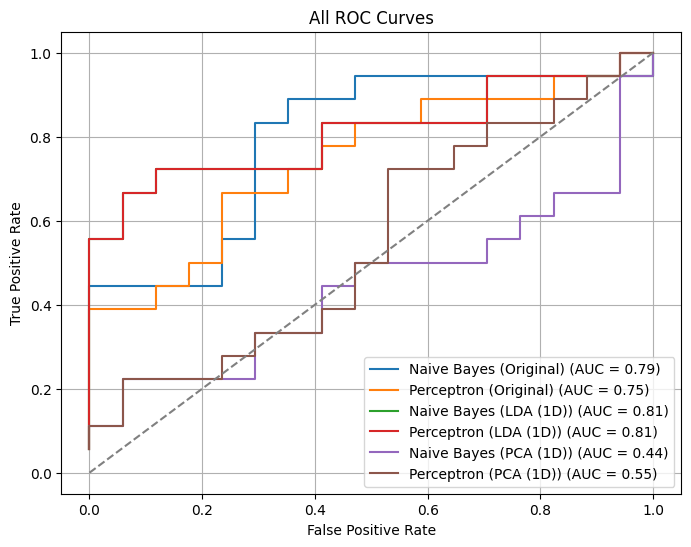

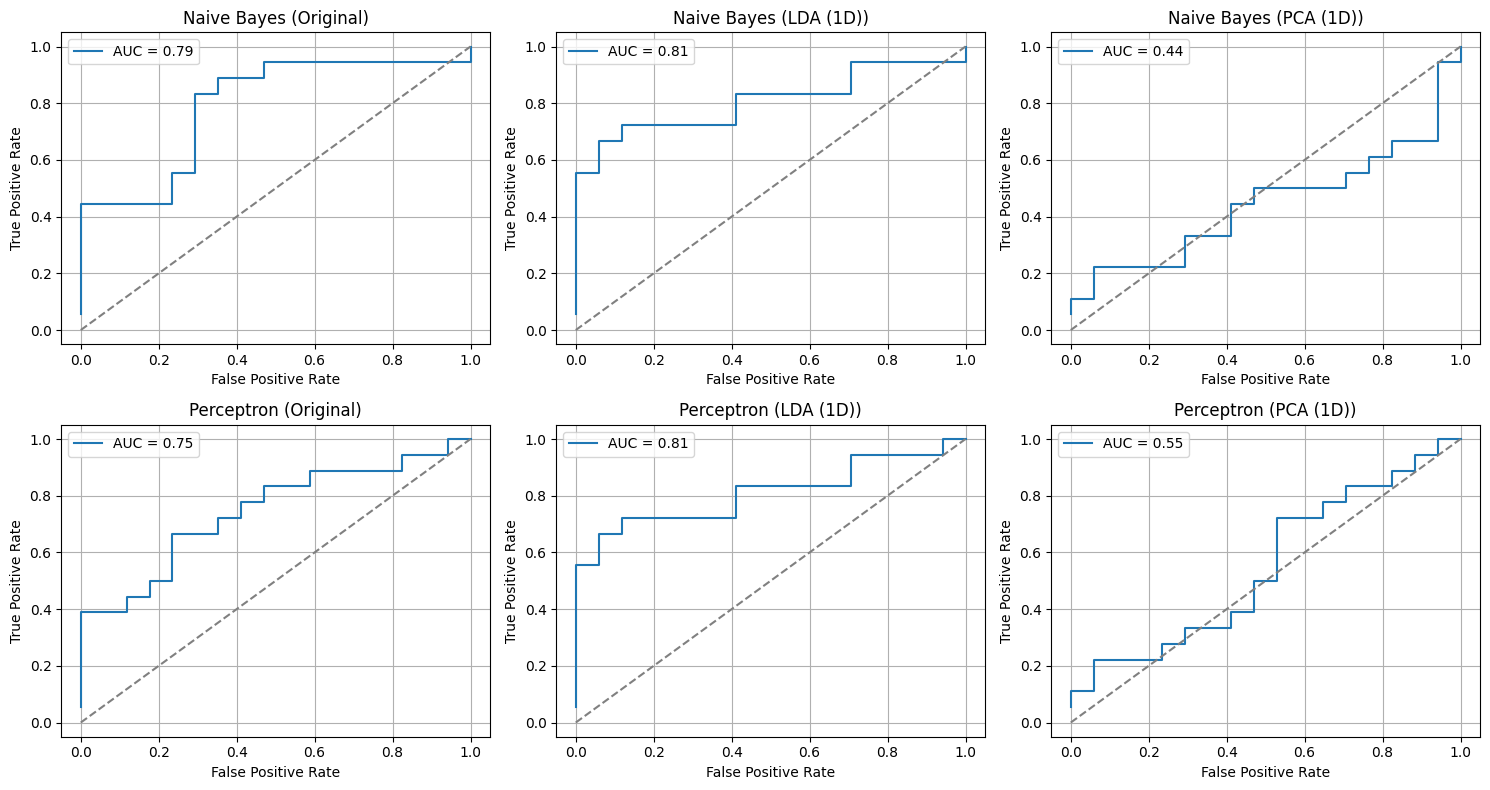

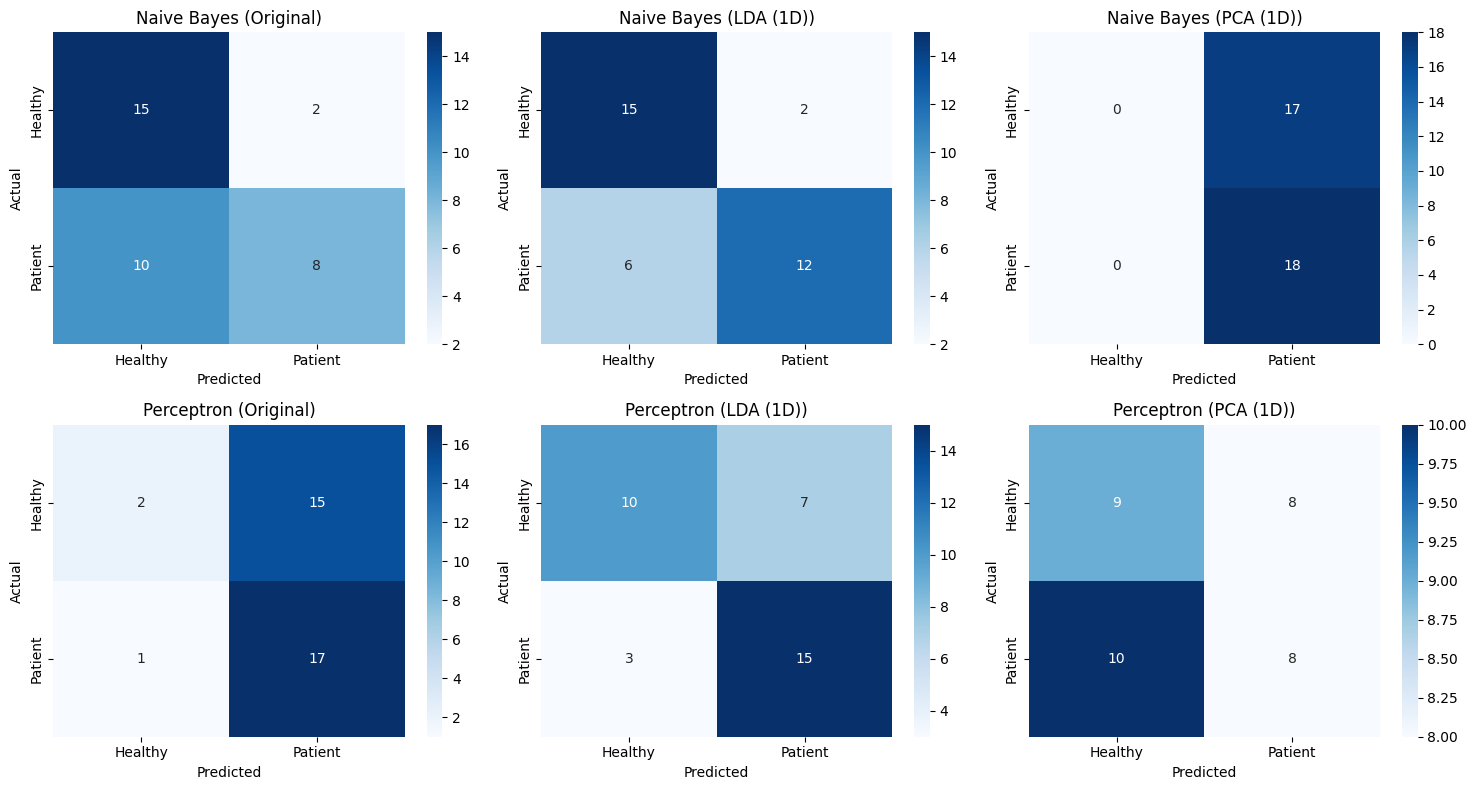


=== Evaluation Summary Table ===
                 Label  Accuracy  Precision   Recall  F1 Score      AUC
Naive Bayes (Original)  0.657143   0.800000 0.444444  0.571429 0.790850
 Perceptron (Original)  0.542857   0.531250 0.944444  0.680000 0.745098
Naive Bayes (LDA (1D))  0.771429   0.857143 0.666667  0.750000 0.807190
 Perceptron (LDA (1D))  0.714286   0.681818 0.833333  0.750000 0.810458
Naive Bayes (PCA (1D))  0.514286   0.514286 1.000000  0.679245 0.444444
 Perceptron (PCA (1D))  0.485714   0.500000 0.444444  0.470588 0.549020


In [3]:
run_pipeline(load_breast_cancer_coimbra_dataset,num_components_pca=1, num_components_lda=1)

# Ionosphere
351 samples, 34 features, 2 classes (high dimensional)


[Naive Bayes - Original]
Confusion Matrix:
[[33  6]
 [ 5 62]]
Accuracy: 0.8962
Precision: 0.9118, Recall: 0.9254, F1 Score: 0.9185
AUC: 0.9571

[Perceptron - Original]
Confusion Matrix:
[[26 13]
 [ 1 66]]
Accuracy: 0.8679
Precision: 0.8354, Recall: 0.9851, F1 Score: 0.9041
AUC: 0.8331

=== FLD / LDA Projection ===

[Naive Bayes - LDA (1D)]
Confusion Matrix:
[[24 15]
 [ 2 65]]
Accuracy: 0.8396
Precision: 0.8125, Recall: 0.9701, F1 Score: 0.8844
AUC: 0.8615

[Perceptron - LDA (1D)]
Confusion Matrix:
[[25 14]
 [ 2 65]]
Accuracy: 0.8491
Precision: 0.8228, Recall: 0.9701, F1 Score: 0.8904
AUC: 0.8638

=== PCA Projection ===

[Naive Bayes - PCA (17D)]
Confusion Matrix:
[[33  6]
 [ 2 65]]
Accuracy: 0.9245
Precision: 0.9155, Recall: 0.9701, F1 Score: 0.9420
AUC: 0.9816

[Perceptron - PCA (17D)]
Confusion Matrix:
[[33  6]
 [ 3 64]]
Accuracy: 0.9151
Precision: 0.9143, Recall: 0.9552, F1 Score: 0.9343
AUC: 0.9365


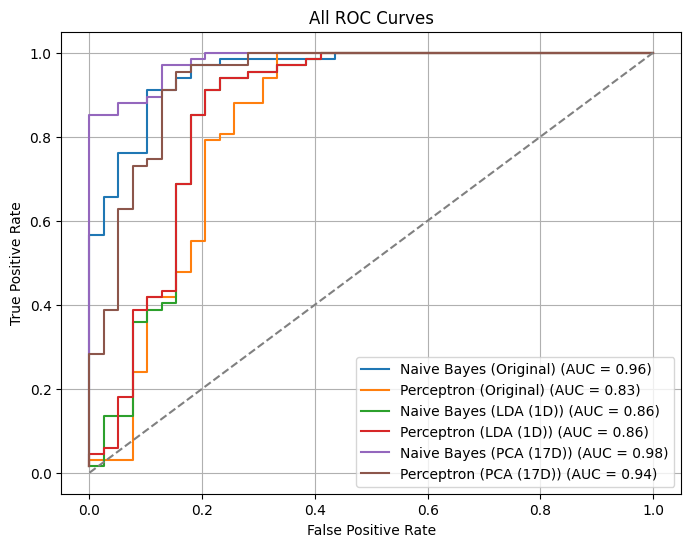

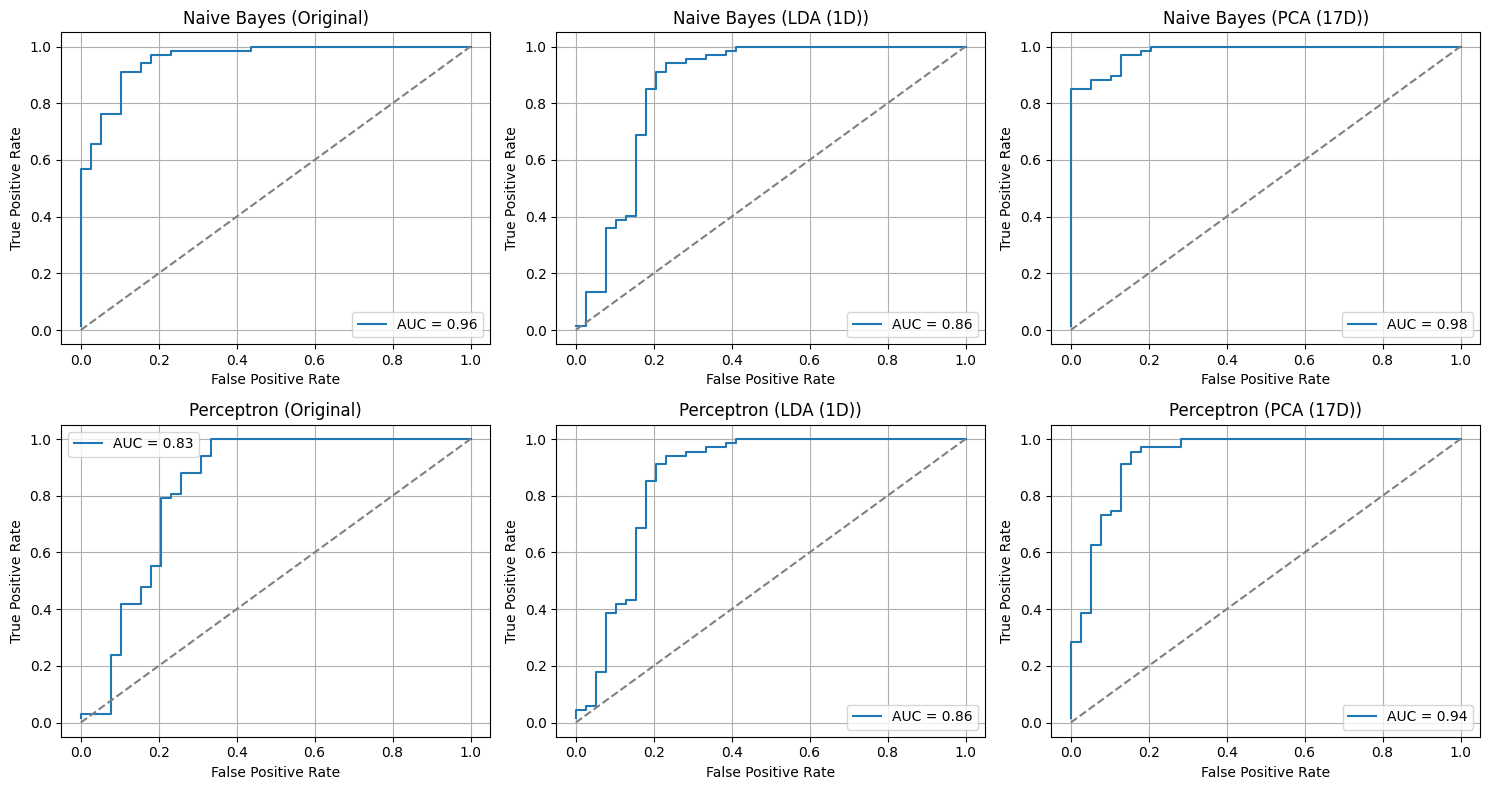

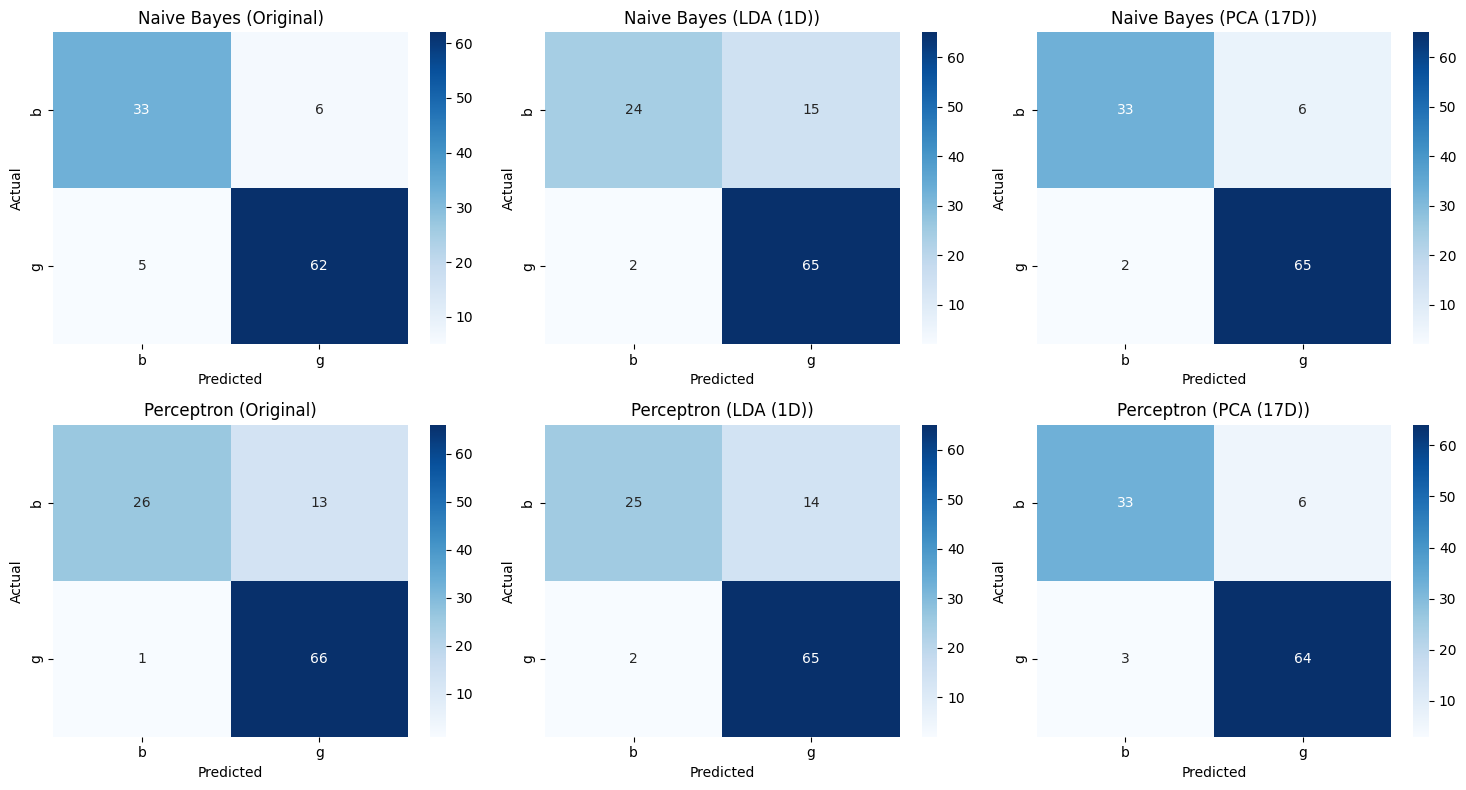


=== Evaluation Summary Table ===
                  Label  Accuracy  Precision   Recall  F1 Score      AUC
 Naive Bayes (Original)  0.896226   0.911765 0.925373  0.918519 0.957137
  Perceptron (Original)  0.867925   0.835443 0.985075  0.904110 0.833142
 Naive Bayes (LDA (1D))  0.839623   0.812500 0.970149  0.884354 0.861462
  Perceptron (LDA (1D))  0.849057   0.822785 0.970149  0.890411 0.863758
Naive Bayes (PCA (17D))  0.924528   0.915493 0.970149  0.942029 0.981630
 Perceptron (PCA (17D))  0.915094   0.914286 0.955224  0.934307 0.936471


In [4]:
run_pipeline(load_ionosphere_dataset, num_components_pca=17, num_components_lda=1)

# Iris
150 samples, 4 features, 3 classes (3 balanced classes)


[Naive Bayes - Original]
Confusion Matrix:
[[19  0  0]
 [ 0 12  1]
 [ 0  0 13]]
Accuracy: 0.9778
Macro Precision: 0.9762, Recall: 0.9744, F1 Score: 0.9743

[Perceptron - Original]
Confusion Matrix:
[[19  0  0]
 [ 0 13  0]
 [ 0 13  0]]
Accuracy: 0.7111
Macro Precision: 0.5000, Recall: 0.6667, F1 Score: 0.5556

=== FLD / LDA Projection ===

[Naive Bayes - LDA (2D)]
Confusion Matrix:
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]
Accuracy: 1.0000
Macro Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000

[Perceptron - LDA (2D)]
Confusion Matrix:
[[19  0  0]
 [ 0 13  0]
 [ 0 13  0]]
Accuracy: 0.7111
Macro Precision: 0.5000, Recall: 0.6667, F1 Score: 0.5556

=== PCA Projection ===

[Naive Bayes - PCA (2D)]
Confusion Matrix:
[[19  0  0]
 [ 0  8  5]
 [ 0  0 13]]
Accuracy: 0.8889
Macro Precision: 0.9074, Recall: 0.8718, F1 Score: 0.8669

[Perceptron - PCA (2D)]
Confusion Matrix:
[[19  0  0]
 [ 0 13  0]
 [ 0 13  0]]
Accuracy: 0.7111
Macro Precision: 0.5000, Recall: 0.6667, F1 Score: 0.5556


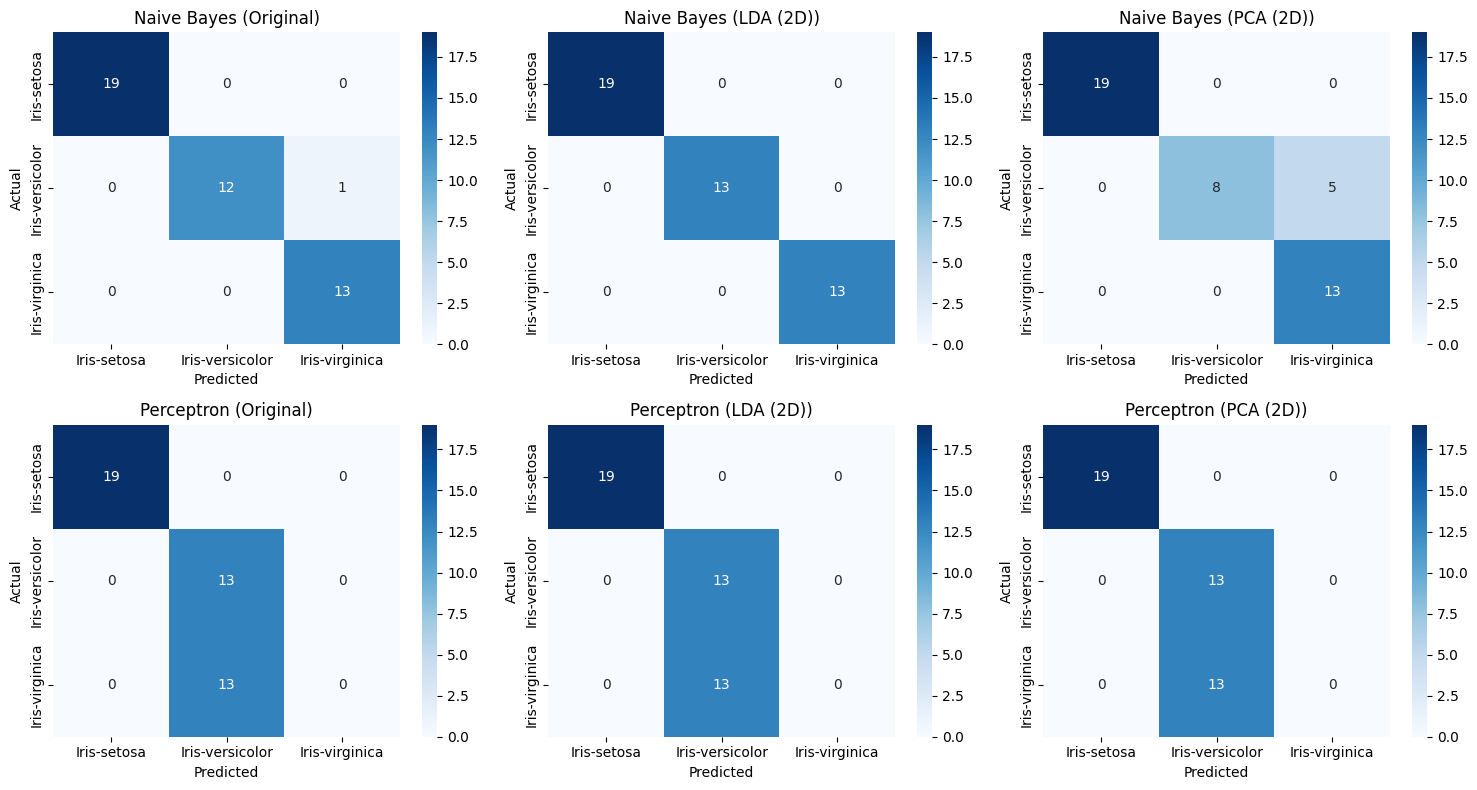


=== Evaluation Summary Table ===
                 Label  Accuracy  Precision   Recall  F1 Score  AUC
Naive Bayes (Original)  0.977778   0.976190 0.974359  0.974321 None
 Perceptron (Original)  0.711111   0.500000 0.666667  0.555556 None
Naive Bayes (LDA (2D))  1.000000   1.000000 1.000000  1.000000 None
 Perceptron (LDA (2D))  0.711111   0.500000 0.666667  0.555556 None
Naive Bayes (PCA (2D))  0.888889   0.907407 0.871795  0.866871 None
 Perceptron (PCA (2D))  0.711111   0.500000 0.666667  0.555556 None


In [5]:
run_pipeline(load_iris_dataset, num_components_pca=2,num_components_lda=2)

# Wine
178 samples, 13 features, 3 classes (more complex)


[Naive Bayes - Original]
Confusion Matrix:
[[19  0  0]
 [ 0 21  0]
 [ 0  0 14]]
Accuracy: 1.0000
Macro Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000

[Perceptron - Original]
Confusion Matrix:
[[19  0  0]
 [ 5 16  0]
 [ 2 12  0]]
Accuracy: 0.6481
Macro Precision: 0.4341, Recall: 0.5873, F1 Score: 0.4992

=== FLD / LDA Projection ===

[Naive Bayes - LDA (2D)]
Confusion Matrix:
[[19  0  0]
 [ 0 21  0]
 [ 0  0 14]]
Accuracy: 1.0000
Macro Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000

[Perceptron - LDA (2D)]
Confusion Matrix:
[[19  0  0]
 [ 0 21  0]
 [ 0 14  0]]
Accuracy: 0.7407
Macro Precision: 0.5333, Recall: 0.6667, F1 Score: 0.5833

=== PCA Projection ===

[Naive Bayes - PCA (6D)]
Confusion Matrix:
[[19  0  0]
 [ 0 21  0]
 [ 0  0 14]]
Accuracy: 1.0000
Macro Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000

[Perceptron - PCA (6D)]
Confusion Matrix:
[[19  0  0]
 [ 0 21  0]
 [ 0 14  0]]
Accuracy: 0.7407
Macro Precision: 0.5333, Recall: 0.6667, F1 Score: 0.5833


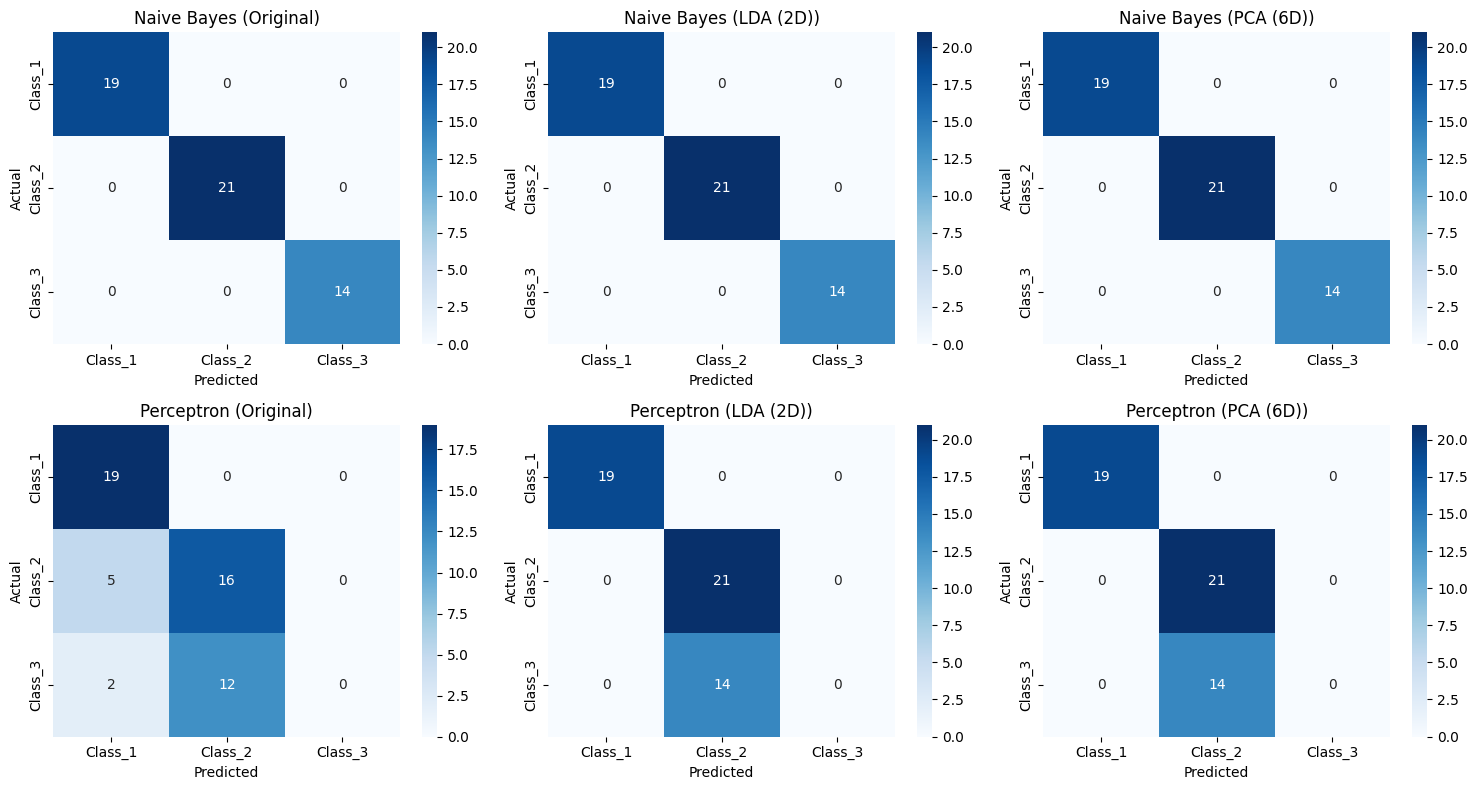


=== Evaluation Summary Table ===
                 Label  Accuracy  Precision   Recall  F1 Score  AUC
Naive Bayes (Original)  1.000000   1.000000 1.000000  1.000000 None
 Perceptron (Original)  0.648148   0.434066 0.587302  0.499169 None
Naive Bayes (LDA (2D))  1.000000   1.000000 1.000000  1.000000 None
 Perceptron (LDA (2D))  0.740741   0.533333 0.666667  0.583333 None
Naive Bayes (PCA (6D))  1.000000   1.000000 1.000000  1.000000 None
 Perceptron (PCA (6D))  0.740741   0.533333 0.666667  0.583333 None


In [6]:
run_pipeline(load_wine_dataset,num_components_pca=6,num_components_lda=2)